# Exploratory Data Analysis (EDA)

## Objective
The goal of this notebook is to understand the structure of the Home Credit Default Risk dataset, explore key drivers of loan default, and identify data quality issues that will inform feature engineering and modeling decisions.

This analysis focuses on:
- Target variable distribution and class imbalance
- Key applicant characteristics related to default risk
- Missing data patterns and potential signal in missingness
- Early insights that guide modeling choices

---

## Dataset Overview
Primary dataset:
- `application_train.csv`: Loan application data with default labels (`TARGET`)

Key target definition:
- `TARGET = 1`: Client defaulted on loan
- `TARGET = 0`: Client repaid loan

---

## Key Questions
1. What proportion of applicants default?
2. Which applicant features show clear separation between defaulters and non-defaulters?
3. How severe is class imbalance?
4. Which variables have high missingness, and is missingness informative?
5. Are there obvious data quality issues (outliers, impossible values)?

---

## EDA Plan
1. Load and inspect data
2. Examine target distribution
3. Analyze numeric features vs target
4. Analyze categorical features vs target
5. Investigate missing values
6. Summarize findings and modeling implications


## 1. Load and Inspect Data

In [3]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.3f}".format)

# Plot style
sns.set(style="whitegrid")


In [19]:
DATA_PATH = "data/home-credit-default-risk/application_train.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()


Shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.500,24700.500,351000.000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.019,-9461,-637,-3648.000,-2120,NaN,1,1,0,1,1,0,Laborers,1.000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.263,0.139,0.025,0.037,0.972,0.619,0.014,0.000,0.069,0.083,0.125,0.037,0.020,0.019,0.000,0.000,0.025,0.038,0.972,0.634,0.014,0.000,0.069,0.083,0.125,0.038,0.022,0.020,0.000,0.000,0.025,0.037,0.972,0.624,0.014,0.000,0.069,0.083,0.125,0.037,0.021,0.019,0.000,0.000,reg oper account,block of flats,0.015,"Stone, brick",No,2.000,2.000,2.000,2.000,-1134.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.500,35698.500,1129500.000,Family,State servant,Higher education,Married,House / apartment,0.004,-16765,-1188,-1186.000,-291,NaN,1,1,0,1,1,0,Core staff,2.000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311,0.622,NaN,0.096,0.053,0.985,0.796,0.060,0.080,0.035,0.292,0.333,0.013,0.077,0.055,0.004,0.010,0.092,0.054,0.985,0.804,0.050,0.081,0.035,0.292,0.333,0.013,0.079,0.055,0.000,0.000,0.097,0.053,0.985,0.799,0.061,0.080,0.035,0.292,0.333,0.013,0.079,0.056,0.004,0.010,reg oper account,block of flats,0.071,Block,No,1.000,0.000,1.000,0.000,-828.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.000,6750.000,135000.000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010,-19046,-225,-4260.000,-2531,26.000,1,1,1,1,1,0,Laborers,1.000,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.556,0.730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [21]:
target_counts = df["TARGET"].value_counts()
target_rates = df["TARGET"].value_counts(normalize=True)

summary = pd.DataFrame({
    "count": target_counts,
    "percent": (target_rates * 100).round(2)
})

summary

,count,percent
TARGET,,
0,282686,91.930
1,24825,8.070


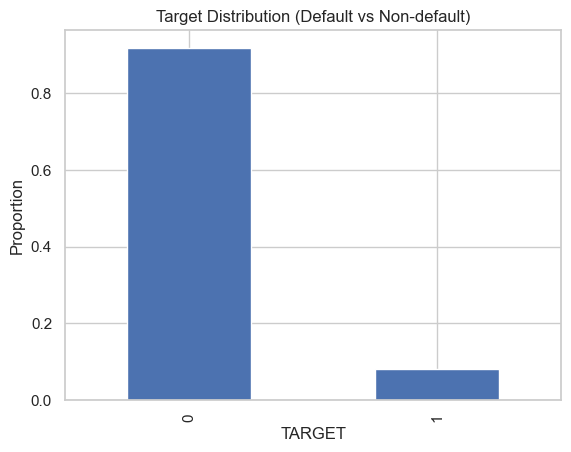

In [22]:
ax = target_rates.sort_index().plot(kind="bar")
ax.set_title("Target Distribution (Default vs Non-default)")
ax.set_xlabel("TARGET")
ax.set_ylabel("Proportion")
plt.show()

### EDA Takeaways: Target Variable
- The dataset contains approximately 307k loan applications with 122 features
- Default rate (`TARGET = 1`) is approximately 8%, indicating significant class imbalance
- This imbalance suggests that accuracy alone will be a misleading metric
- Precision, recall, and threshold selection will be important in downstream modeling